# Homework 5

### Cassandra Bodin


Worked with: Mackenzie, Ryan, Madison, Sean, Jimmy

In [50]:
# import modules
import numpy as np
import astropy
import astropy.units as u
import astropy.table as tbl
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline 

#import the read file and center of mass file
from ReadFile import Read
from CenterOfMass import CenterOfMass
from astropy.constants import G

## Section 1-7

In [51]:
##Part1
# Class to define mass profile of a given galaxy and simulation snapshot
class MassProfile:  
    
    def __init__(self, snap, galaxy):
        
        #Inputs:
        #snap, Snapshot number
        #galaxy, a string with the Galaxy name (ie MW, M31, M33)

        #add a string of the filenumber to the value "000"
        ilbl= '000' +str(snap)
        #remove all but the last 3 digits
        ilbl=ilbl[-3:]
        self.filename="%s_"%(galaxy) + ilbl + '.txt'
    
        # read data in the given file using Read
        self.time, self.total, self.data = Read(self.filename)                                                                                             


        # store the mass and positions of only the particles
        self.m = self.data['m']
        self.x = self.data['x']*u.kpc
        self.y = self.data['y']*u.kpc
        self.z = self.data['z']*u.kpc
        
        # store the galaxy name
        self.gname="%s_"%(galaxy)
     
    #Part 2
    #Function to calculate the mass enclosed within a radius
    def MassEnclosed(self,ptype,r):
        #Inputs:
        #ptype, the particle type
        #     Halo:1
        #     Disk:2
        #     Bulge:3
        #r, an array of radii, magnitude not vector quantities (kpc)
        
        #Returns:
        #mencl, array of masses enclosed in radius (Msun)
        
        #create an array to store indexes of particles of desired Ptype                                
        self.index = np.where(self.data['type'] == ptype)

        # store the mass, positions, velocities of only the particles of the given type
        self.m = self.data['m'][self.index]*1e10 #data in 1e10Msun
        self.x = self.data['x'][self.index]*u.kpc
        self.y = self.data['y'][self.index]*u.kpc
        self.z = self.data['z'][self.index]*u.kpc
        
        # read COM Position data in the given file using COM_P
        COM = CenterOfMass(self.filename,2)
        COMP=COM.COM_P(0.1) #note we are defining alpha=0.1
        
        # Test, MW COM Position is [-2.07  2.95 -1.45] kpc
        #print("COMP is",COMP)

        
        #initialize an empty array
        mencl= np.zeros(len(r))
        
        
        #define a radius
        R=((self.x-COMP[0])**2+(self.y-COMP[1])**2+(self.z-COMP[2])**2)**(1/2)
            
        #for loop to cycle through each radius inside
        for i in range(len(r)):
                    
            #select all particles within the reduced radius 
            #    starting from original x,y,z, m         
            index = np.where(R < r[i])
            mnew = self.m[index]
            
            #sum all of the masses within that radius
            mencl[i]=np.sum(mnew)
            
        return mencl*u.Msun
    
    ##Part3
    #Function to calculate the mass enclosed within a radius
    def MassEnclosedTotal(self,r):
        #Inputs:
        #r, a 1D array of radii (kpc)
        
        #Returns:
        #mtot, array of masses (Msun)
        
        
        #Define mass enclosed in terms of each of the particle types
        #     Halo:1
        #     Disk:2
        #     Bulge:3
        mhalo= self.MassEnclosed(1,r)
        mdisk= self.MassEnclosed(2,r)
        mbulge= self.MassEnclosed(3,r)
        
        #M33 has no bulge so take this into account with if statement
        if self.gname == 'M33':
            Mtotencl = mhalo+mdisk
        else:
            Mtotencl = mhalo+mdisk+mbulge
            
        return Mtotencl
    
    ##Part4
    #Note:used code from lab3
    #create a function that returns the Hernquist 1990 Mass profile
    def HernquistMass(self,r,a,mhalo):
        #Inputs:
        #r, the distance from the galactic center (kpc)
        #a, the scale radius (kpc)
        #mhalo, total mass of the dark matter halo (1e12*Msun)

        #Returns:
        #total darkmatter mass enclosed within radius r (Msun)
        mhalo= self.MassEnclosed(1,r)

        return np.round(mhalo*r**2/(a+r)**2,2)*1e12*u.Msun
    
    ##Part5
    #create a function to create an array of circular velocities 
    #for each galaxy component at the radius of the input array
    #Vcirc=np.sqrt(G*M/r)
    def CircularVelocity(self, ptype, r):
        #Inputs:
        #r, a 1D array of radii (kpc)
        #ptype, the particle type
        #     Halo:1
        #     Disk:2
        #     Bulge:3
        
        #Returns:
        #Vcirc, an array of the circular velocity at each r (km/s)
        g = G.to(u.kpc*u.km**2/u.s**2/u.Msun)
        M=self.MassEnclosed(ptype,r)
        
        return np.sqrt(g*M/r)
    
    ##Part6
    #create a function to create an array of total circular velocities 
    #for each galaxy component at the radius of the input array
    #Vcirc=np.sqrt(G*M/r)
    def CircularVelocityTotal(self,r):
        #Inputs:
        #r, a 1D array of radii (kpc)
        
        #Returns:
        #Vcirc, an array of the total circular velocity at each r (km/s)
        
        g = G.to(u.kpc*u.km**2/u.s**2/u.Msun)
        M=self.MassEnclosedTotal(ptype,r)
        
        return np.sqrt(g*M/r)
    
    ##Part7
    #create a function to create an array of circular velocities
    #using the Hernquist mass profile.
    #Vcirc=np.sqrt(G*M/r)
    def HernquistVCirc(self,r,a,mhalo):
        #Inputs:
        #r, the distance from the galactic center (kpc)
        #a, the scale radius (kpc)
        #Mhalo, total mass of the dark matter halo (1e12*Msun)

        #Returns:
        #the Hernquist circular velocity (km/s)
        
        mhalo= self.MassEnclosed(1,r)
        
        g = G.to(u.kpc*u.km**2/u.s**2/u.Msun)
        M=self.HernquistMass(r,a,mhalo)
        
        return np.sqrt(g*M/r)
        

## Section 8

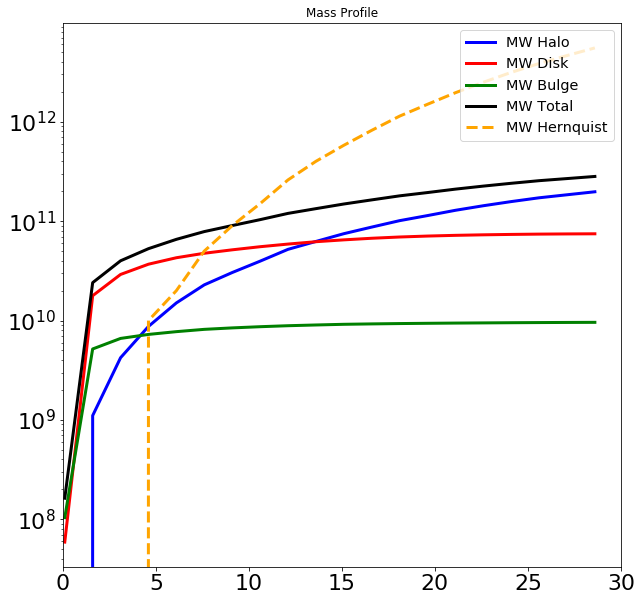

In [94]:
# Plot Mass Profile of each component of the MW 
#to a radius of 30kpc
        #ptype, the particle type
        #     Halo:1
        #     Disk:2
        #     Bulge:3

#initializes mass profile class for MW
MW=MassProfile(0,"MW") 

r=np.arange(0.1,30,1.5)*u.kpc
MassMwHalo=MW.MassEnclosed(1,r)
MassMwDisk=MW.MassEnclosed(2,r)
MassMwBulge=MW.MassEnclosed(3,r)
MassMwTotal=MW.MassEnclosedTotal(r)
MassMwHq= MW.HernquistMass(r,5.4e6*u.kpc,1.975) #mhalomw=1.975 *see hw3


fig = plt.figure(figsize=(10,10))  # sets the scale of the figure
ax = plt.subplot(111) 

# Plot the default values (y axis log)
ax.semilogy(r, MassMwHalo, color='blue', linewidth=3, label='MW Halo')
ax.semilogy(r, MassMwDisk, color='red', linewidth=3, label='MW Disk')
ax.semilogy(r, MassMwBulge, color='green', linewidth=3, label='MW Bulge')
ax.semilogy(r, MassMwTotal, color='black', linewidth=3, label='MW Total')
ax.semilogy(r, MassMwHq, color='orange', linewidth=3, linestyle="--", label='MW Hernquist')

#Add title
plt.title("Mass Profile")

# Add labels
plt.xlabel('', fontsize=22)
plt.ylabel('', fontsize=22)

#set axis limits
plt.xlim(0,30)

#adjust tick label font size
label_size = 22
matplotlib.rcParams['xtick.labelsize'] = label_size 
matplotlib.rcParams['ytick.labelsize'] = label_size

# add a legend with some customizations.
legend = ax.legend(loc='upper right',fontsize='x-large')


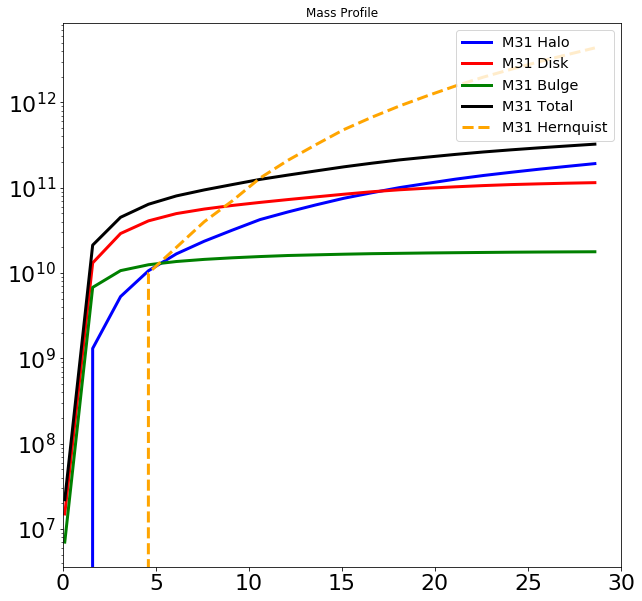

In [97]:
# Plot Mass Profile of each component of the MW 
#to a radius of 30kpc
        #ptype, the particle type
        #     Halo:1
        #     Disk:2
        #     Bulge:3

#initializes mass profile class for MW
M31=MassProfile(0,"M31") 

r=np.arange(0.1,30,1.5)*u.kpc
MassM31Halo=M31.MassEnclosed(1,r)
MassM31Disk=M31.MassEnclosed(2,r)
MassM31Bulge=M31.MassEnclosed(3,r)
MassM31Total=M31.MassEnclosedTotal(r)
MassM31Hq= M31.HernquistMass(r,6e6*u.kpc,1.921)

fig = plt.figure(figsize=(10,10))  # sets the scale of the figure
ax = plt.subplot(111) 

# Plot the default values (y axis log)
ax.semilogy(r, MassM31Halo, color='blue', linewidth=3, label='M31 Halo')
ax.semilogy(r, MassM31Disk, color='red', linewidth=3, label='M31 Disk')
ax.semilogy(r, MassM31Bulge, color='green', linewidth=3, label='M31 Bulge')
ax.semilogy(r, MassM31Total, color='black', linewidth=3, label='M31 Total')
ax.semilogy(r, MassM31Hq, color='orange', linewidth=3, linestyle="--", label='M31 Hernquist')


#Add title
plt.title("Mass Profile")

# Add labels
plt.xlabel('', fontsize=22)
plt.ylabel('', fontsize=22)

#set axis limits
plt.xlim(0,30)

#adjust tick label font size
label_size = 22
matplotlib.rcParams['xtick.labelsize'] = label_size 
matplotlib.rcParams['ytick.labelsize'] = label_size

# add a legend with some customizations.
legend = ax.legend(loc='upper right',fontsize='x-large')


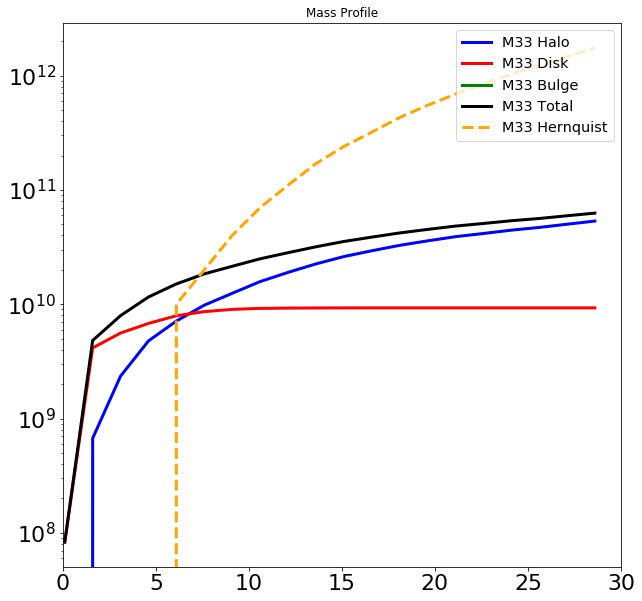

In [98]:
# Plot Mass Profile of each component of the MW 
#to a radius of 30kpc
        #ptype, the particle type
        #     Halo:1
        #     Disk:2
        #     Bulge:3

#initializes mass profile class for MW
M33=MassProfile(0,"M33") 

r=np.arange(0.1,30,1.5)*u.kpc
MassM33Halo=M33.MassEnclosed(1,r)
MassM33Disk=M33.MassEnclosed(2,r)
MassM33Bulge=M33.MassEnclosed(3,r)
MassM33Total=M33.MassEnclosedTotal(r)
MassM33Hq= M33.HernquistMass(r,5e6*u.kpc,0.178)



fig = plt.figure(figsize=(10,10))  # sets the scale of the figure
ax = plt.subplot(111) 

# Plot the default values (y axis log)
ax.semilogy(r, MassM33Halo, color='blue', linewidth=3, label='M33 Halo')
ax.semilogy(r, MassM33Disk, color='red', linewidth=3, label='M33 Disk')
ax.semilogy(r, MassM33Bulge, color='green', linewidth=3, label='M33 Bulge')
ax.semilogy(r, MassM33Total, color='black', linewidth=3, label='M33 Total')
ax.semilogy(r, MassM33Hq, color='orange', linewidth=3, linestyle="--", label='M33 Hernquist')


#Add title
plt.title("Mass Profile")

# Add labels
plt.xlabel('', fontsize=22)
plt.ylabel('', fontsize=22)

#set axis limits
plt.xlim(0,30)

#adjust tick label font size
label_size = 22
matplotlib.rcParams['xtick.labelsize'] = label_size 
matplotlib.rcParams['ytick.labelsize'] = label_size

# add a legend with some customizations.
legend = ax.legend(loc='upper right',fontsize='x-large')

## Section 9

In [55]:
# Plot Rotation curve of each galaxy 
#to a radius of 30kpc
        #ptype, the particle type
        #     Halo:1
        #     Disk:2
        #     Bulge:3

#define the radius
r=np.arange(0.1,30,1.5)*u.kpc

#initializes mass profile class for MW
MW=MassProfile(0,"MW") 
MwHalo=MW.CircularVelocity(1,r)
MwDisk=MW.CircularVelocity(2,r)
MwBulge=MW.CircularVelocity(3,r)
MwTotal=MW.CircularVelocityTotal(r)


fig = plt.figure(figsize=(10,10))  # sets the scale of the figure
ax = plt.subplot(111) 

# Plot the default values (y axis log)
#MW data
ax.semilogy(r, MwHalo, color='aqua', linewidth=3, label='MW Halo')
ax.semilogy(r, MwDisk, color='darkturquoise', linewidth=3, label='MW Disk')
ax.semilogy(r, MwBulge, color='steelblue', linewidth=3, label='MW Bulge')
ax.semilogy(r, MwTotal, color='deepskyblue', linewidth=3, label='MW Total')

#Add title
plt.title("Rotation Curve")

# Add labels
plt.xlabel('', fontsize=22)
plt.ylabel('', fontsize=22)

#set axis limits
plt.xlim(0,30)

#adjust tick label font size
label_size = 22
matplotlib.rcParams['xtick.labelsize'] = label_size 
matplotlib.rcParams['ytick.labelsize'] = label_size

# add a legend with some customizations.
legend = ax.legend(loc='upper right',fontsize='x-large')


TypeError: object of type 'int' has no len()

In [ ]:
# Plot Rotation curve of each galaxy 
#to a radius of 30kpc
        #ptype, the particle type
        #     Halo:1
        #     Disk:2
        #     Bulge:3

#define the radius
r=np.arange(0.1,30,1.5)*u.kpc


#initializes mass profile class for M31
M31=MassProfile(0,"M31") 
M31Halo=M31.CircularVelocity(1,r)
M31Disk=M31.CircularVelocity(2,r)
M31Bulge=M31.CircularVelocity(3,r)
M31Total=M31.CircularVelocityTotal(r)


fig = plt.figure(figsize=(10,10))  # sets the scale of the figure
ax = plt.subplot(111) 

# Plot the default values (y axis log)
#M31 data
ax.semilogy(r, M31Halo, color='lightcoral', linewidth=3, label='M31 Halo')
ax.semilogy(r, M31Disk, color='indianred', linewidth=3, label='M31 Disk')
ax.semilogy(r, M31Bulge, color='maroon', linewidth=3, label='M31 Bulge')
ax.semilogy(r, M31Total, color='bfirebrick', linewidth=3, label='M31 Total')

#Add title
plt.title("Rotation Curve")

# Add labels
plt.xlabel('', fontsize=22)
plt.ylabel('', fontsize=22)

#set axis limits
plt.xlim(0,30)

#adjust tick label font size
label_size = 22
matplotlib.rcParams['xtick.labelsize'] = label_size 
matplotlib.rcParams['ytick.labelsize'] = label_size

# add a legend with some customizations.
legend = ax.legend(loc='upper right',fontsize='x-large')


In [ ]:
# Plot Rotation curve of each galaxy 
#to a radius of 30kpc
        #ptype, the particle type
        #     Halo:1
        #     Disk:2
        #     Bulge:3

#define the radius
r=np.arange(0.1,30,1.5)*u.kpc

#initializes mass profile class for M33
M33=MassProfile(0,"M33") 
M33Halo=M33.CircularVelocity(1,r)
M33Disk=M33.CircularVelocity(2,r)
M33Bulge=M33.CircularVelocity(3,r)
M33Total=M33.CircularVelocityTotal(r)



fig = plt.figure(figsize=(10,10))  # sets the scale of the figure
ax = plt.subplot(111) 

# Plot the default values (y axis log)
#M33 data
ax.semilogy(r, M33Halo, color='violet', linewidth=3, label='M33 Halo')
ax.semilogy(r, M33Disk, color='darkmagenta', linewidth=3, label='M33 Disk')
ax.semilogy(r, M33Bulge, color='hotpink', linewidth=3, label='M33 Bulge')
ax.semilogy(r, M33Total, color='pink', linewidth=3, label='M33 Total')

#Add title
plt.title("Rotation Curve")

# Add labels
plt.xlabel('', fontsize=22)
plt.ylabel('', fontsize=22)

#set axis limits
plt.xlim(0,30)

#adjust tick label font size
label_size = 22
matplotlib.rcParams['xtick.labelsize'] = label_size 
matplotlib.rcParams['ytick.labelsize'] = label_size

# add a legend with some customizations.
legend = ax.legend(loc='upper right',fontsize='x-large')


## Tests

#### Test Part 2!!!

In [ ]:
MW=MassProfile(0,"MW") #initializes mass profile class for MW

r=np.arange(0.25,30.5,1.5)*u.kpc #set radii range
print("rvalues",r) #print

MW.MassEnclosed(1,r) #get enclosed halo masses at each r element

#### Test Part 3!!!

In [ ]:
MW=MassProfile(0,"MW") #initializes mass profile class for MW

r=np.arange(0.25,30.5,1.5)*u.kpc #set radii range
print("rvalues",r) #print

MW.MassEnclosedTotal(r) #get enclosed halo masses at each r element